In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import minimize
from tqdm import tqdm
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
n = 1000
mc_samples = 50

naive_losses = np.zeros(mc_samples).astype(float) # minimax strategy
ure_losses = np.zeros(mc_samples).astype(float)
pstrategy_losses = np.zeros(mc_samples).astype(float)
tilt_losses = np.zeros(mc_samples).astype(float)
better_tilt_losses = np.zeros(mc_samples).astype(float)


sds = np.ones(n)

for i in tqdm(range(mc_samples)):
    true_vals = np.random.uniform(-2,3, n)
    #true_vals = np.concatenate((np.random.normal(-1, 1, int(n/2)), np.random.normal(0,10,int(n/2))))
    #true_vals = np.random.normal(-4, 1, n)
    #true_vals = 2*(np.random.normal(0,1, n) > 0 ) - 1
    #true_vals = np.random.standard_cauchy(n)
    optimal_value = true_vals[true_vals > 0].sum()

    
    data = np.random.normal(true_vals, sds)

    # NAIVE
    naive_value = true_vals[data > 0].sum()
    naive_losses[i] = optimal_value - naive_value


    # p-value
    pstrategy_value = true_vals[data/sds > 2].sum()
    pstrategy_losses[i] = optimal_value - pstrategy_value


    # tilt towards mean. Truncate around some portion of zero? Also unclear whether -0.1 is optimal
    tilt = true_vals[data > -np.mean(data)].sum()
    tilt_losses[i] = optimal_value - tilt

    # tilt
    restricted_mean = data[(data < 4) & (data > -4)].mean()
    better_tilt_losses[i] = optimal_value - true_vals[(data > -restricted_mean)].sum()

    # URE
    l = np.min(data/sds**2)
    r = np.max(data/sds**2)
    C_grid = np.linspace(l,r,5000)

    F_1 = np.zeros(len(C_grid)).astype(float)

    for j in range(len(C_grid)):
        F_1[j] = data[data/sds**2 >= C_grid[j]].sum()


    width = 0.02
    res = scipy.stats.ecdf(data/sds**2)
    F_2 = n*(res.cdf.evaluate(C_grid + width) - res.cdf.evaluate(C_grid - width))/(2*width)
    loess_smoothed = lowess(F_1 - F_2, C_grid, frac=0.1, return_sorted = False)

    C = C_grid[np.argmax(F_1 - F_2)]
    ure_eb_decisions = (data > C*(sds**2))
    ure_eb_value = true_vals[ure_eb_decisions].sum()
    ure_losses[i] = optimal_value - ure_eb_value



100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


In [3]:
# computing the mean: these are Bayes risks
print("Naive Risk:", np.mean(naive_losses))
print("P value strategy Risk:", np.mean(pstrategy_losses))
print("URE Risk:", np.mean(ure_losses))
print("Tilt towards mean Risk:", np.mean(tilt_losses))
print("Tilt towards mean Risk:", np.mean(better_tilt_losses))


Naive Risk: 96.87200907522049
P value strategy Risk: 444.25265962707766
URE Risk: 104.58883356257513
Tilt towards mean Risk: 111.7979304439521
Tilt towards mean Risk: 109.06362718952654


In [4]:
# Initialize counters for each algorithm
count_naive = 0
count_pstrategy = 0
count_ure = 0
count_tilt = 0
count_better_tilt = 0

# Initialize lists to store ranks for each dataset
ranks_naive = []
ranks_pstrategy = []
ranks_ure = []
ranks_tilt = []
ranks_better_tilt = []

# Iterate through the arrays and determine the best algorithm and ranks on each dataset
for losses in zip(naive_losses, pstrategy_losses, ure_losses, tilt_losses, better_tilt_losses):
    # Find the index of the minimum loss
    min_loss_index = np.argmin(losses)
    
    # Increment the count for the best algorithm
    if min_loss_index == 0:
        count_naive += 1
    elif min_loss_index == 1:
        count_pstrategy += 1
    elif min_loss_index == 2:
        count_ure += 1
    elif min_loss_index == 3:
        count_tilt += 1
    elif min_loss_index == 4:
        count_better_tilt += 1
    
    # Calculate ranks (1 for best, 5 for worst)
    sorted_losses = sorted(losses)
    ranks_naive.append(sorted_losses.index(losses[0]) + 1)
    ranks_pstrategy.append(sorted_losses.index(losses[1]) + 1)
    ranks_ure.append(sorted_losses.index(losses[2]) + 1)
    ranks_tilt.append(sorted_losses.index(losses[3]) + 1)
    ranks_better_tilt.append(sorted_losses.index(losses[4]) + 1)

# Calculate average ranks
average_rank_naive = np.mean(ranks_naive)
average_rank_pstrategy = np.mean(ranks_pstrategy)
average_rank_ure = np.mean(ranks_ure)
average_rank_tilt = np.mean(ranks_tilt)
average_rank_better_tilt = np.mean(ranks_better_tilt)

# Calculate average losses (risk) for each algorithm
average_loss_naive = np.mean(naive_losses)
average_loss_pstrategy = np.mean(pstrategy_losses)
average_loss_ure = np.mean(ure_losses)
average_loss_tilt = np.mean(tilt_losses)
average_loss_better_tilt = np.mean(better_tilt_losses)

# Print the results
print(f"Naive is the best on {count_naive} datasets.")
print(f"Pstrategy is the best on {count_pstrategy} datasets.")
print(f"URE is the best on {count_ure} datasets.")
print(f"Tilt is the best on {count_tilt} datasets.")

print(f"Average rank of Naive: {average_rank_naive}")
print(f"Average rank of Pstrategy: {average_rank_pstrategy}")
print(f"Average rank of URE: {average_rank_ure}")
print(f"Average rank of Tilt: {average_rank_tilt}")

Naive is the best on 38 datasets.
Pstrategy is the best on 0 datasets.
URE is the best on 6 datasets.
Tilt is the best on 1 datasets.
Average rank of Naive: 1.34
Average rank of Pstrategy: 5.0
Average rank of URE: 2.46
Average rank of Tilt: 3.5


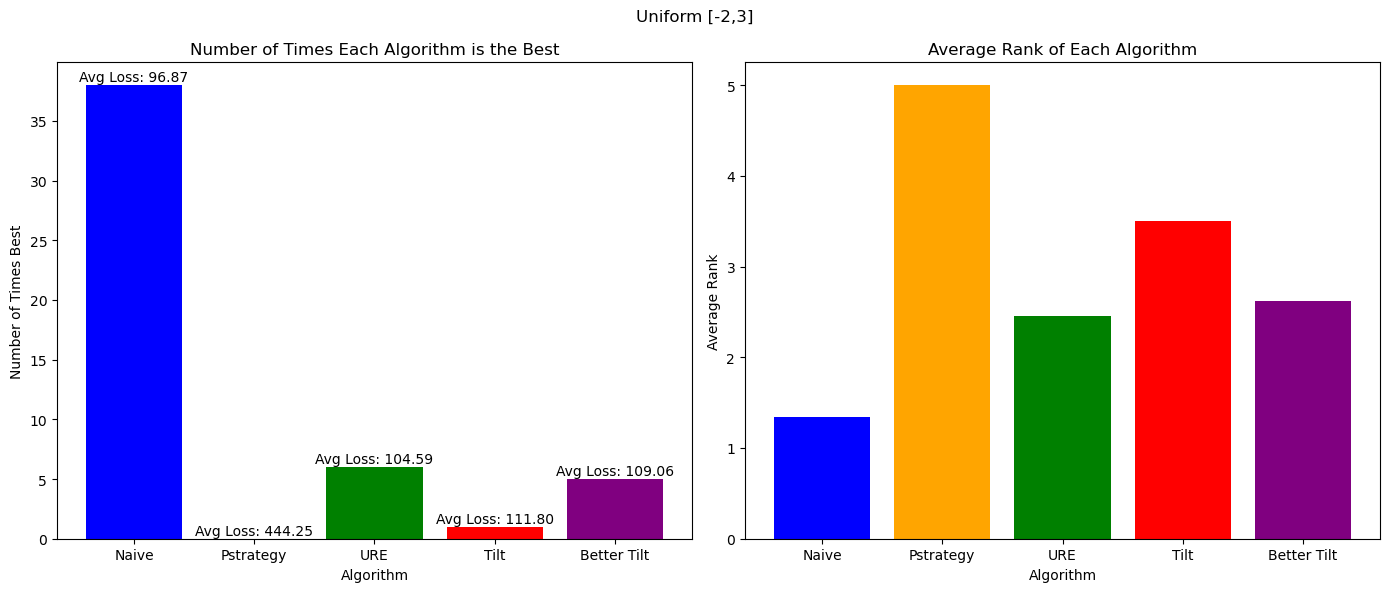

In [5]:
# Plot number of times each algorithm is the best
algorithms = ['Naive', 'Pstrategy', 'URE', 'Tilt', 'Better Tilt']
best_counts = [count_naive, count_pstrategy, count_ure, count_tilt, count_better_tilt]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
bars = plt.bar(algorithms, best_counts, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Algorithm')
plt.ylabel('Number of Times Best')
plt.title('Number of Times Each Algorithm is the Best')
for bar, avg_loss in zip(bars, [average_loss_naive, average_loss_pstrategy, average_loss_ure, average_loss_tilt, average_loss_better_tilt]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'Avg Loss: {avg_loss:.2f}', ha='center', va='bottom')

# Plot average rank of each algorithm
average_ranks = [average_rank_naive, average_rank_pstrategy, average_rank_ure, average_rank_tilt, average_rank_better_tilt]

plt.subplot(1, 2, 2)
bars = plt.bar(algorithms, average_ranks, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Algorithm')
plt.ylabel('Average Rank')
plt.title('Average Rank of Each Algorithm')



plt.suptitle("Uniform [-2,3]")
plt.savefig("compound_comparison10.pdf")

plt.tight_layout()
plt.show()

How can it be that the p-value strategy is better than the MLE in risk?? Sometimes?? Sometimes mu, tau are estimated quite poorly. With large n, this is probably fixed.


To get URE to work, I need to take epsilon appropriately, and definitely not just do the point mass strategy below. When is naive better than MLE?

In [139]:
n = 100
# true_vals = np.concatenate( (np.random.normal(0.5, 0.1, int(n/4)),
#                             np.random.normal(0,1,int(3*n/4)))
#                             )

true_vals = np.random.normal(0.5,0.5,n)
sds = np.ones(n)
data = np.random.normal(true_vals, sds)


# URE
l = np.min(data/sds**2)
r = np.max(data/sds**2)
C_grid = np.linspace(l,r,1000)

F_1 = np.zeros(len(C_grid)).astype(float)

for i in range(len(C_grid)):
    F_1[i] = data[data/sds**2 >= C_grid[i]].sum()

width = n**(-2/3)

res = scipy.stats.ecdf(data/sds**2)
F_2 = n*(res.cdf.evaluate(C_grid + width) - res.cdf.evaluate(C_grid - width))/(2*width)
loess_smoothed = lowess(F_1 - F_2, C_grid, frac=0.1, return_sorted = False)

C = C_grid[np.argmax(loess_smoothed)]

print("URE Decision:", C)
ure_eb_decisions = (data > C*(sds**2))
ure_eb_value = true_vals[ure_eb_decisions].sum()



URE Decision: -0.3567592653784353


In [140]:
#plt.hist(data, bins = 50)

In [141]:
true_risk_fcn = np.zeros(len(C_grid))

for i in range(len(C_grid)):
    true_risk_fcn[i] = (true_vals*stats.norm.cdf(true_vals/sds - C_grid[i]*sds)).sum()
    

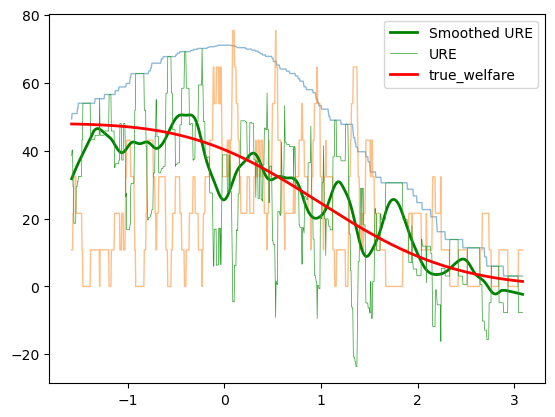

In [142]:
## This plot tells us how much better we can do than the minimax rule. If it can tell us with confidence that zero is not better, we can move directions to somewhere else.

plt.plot(C_grid, F_1, linewidth = 1, alpha = 0.5)
plt.plot(C_grid, F_2, linewidth = 1, alpha = 0.5)

loess_smoothed = lowess(F_1 - F_2, C_grid, frac=0.1, return_sorted = False)
plt.plot(C_grid, loess_smoothed, linewidth = 2, label = "Smoothed URE", color = "green")
plt.plot(C_grid, F_1 - F_2, linewidth = 0.5, label = "URE")
plt.plot(C_grid, true_risk_fcn, linewidth = 2, label = "true_welfare", color = 'red')
plt.legend()
plt.savefig("URE_mixture.pdf")
plt.show()

In [85]:
C_grid[np.argmax(true_risk_fcn)]

-0.09144124347003668

In [86]:
C_grid[np.argmax(loess_smoothed)]

-0.014535777982035647

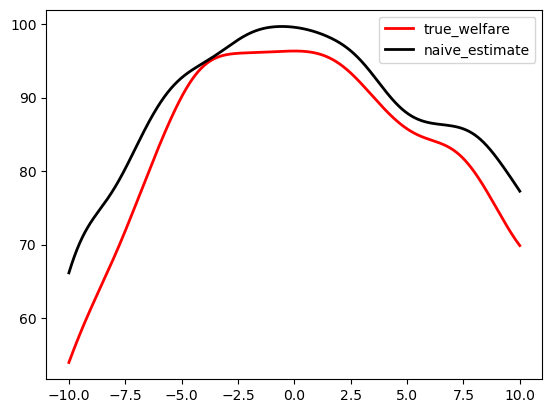

In [179]:
n = 20
true_vals = np.random.normal(0.5,15,n)
data = np.random.normal(true_vals,1)

C_grid = np.linspace(-10,10,3000)
true_risk_fcn = np.zeros(len(C_grid))
naive_est = np.zeros(len(C_grid))

for i in range(len(C_grid)):
    true_risk_fcn[i] = (true_vals*stats.norm.cdf(true_vals - C_grid[i])).sum()
    naive_est[i] = (data*stats.norm.cdf(data - C_grid[i])).sum()

plt.plot(C_grid, true_risk_fcn, linewidth = 2, label = "true_welfare", color = 'red')
plt.plot(C_grid, naive_est, linewidth = 2, label = "naive_estimate", color = 'black')
plt.legend()